# Comprehensive Chorus Example: GATA1 Regulatory Analysis with Enformer

This notebook demonstrates all major features of the Chorus library using the Enformer oracle to analyze the GATA1 transcription start site (TSS) region.

GATA1 is an essential transcription factor for red blood cell development, making it an interesting target for regulatory analysis.

## Installation Instructions (Reference)

If you haven't installed Chorus yet, follow these steps:

```bash
# 1. Clone the repository
git clone https://github.com/pinellolab/chorus.git
cd chorus

# 2. Create the main Chorus environment
mamba env create -f environment.yml
mamba activate chorus

# 3. Install Chorus package
pip install -e .

# 4. Set up the Enformer environment
chorus setup --oracle enformer

# 5. Download the reference genome
chorus genome download hg38
```

**Note**: 
- For this notebook, we assume Chorus is already installed.
- pyGenomeTracks is now included in the environment for advanced visualization!

## Setup and Imports

In [2]:
# Import required libraries
import chorus
from chorus.utils import get_genome, extract_sequence, download_gencode
from chorus.utils.visualization import visualize_chorus_predictions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set up matplotlib for inline display
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt

# Set up plotting with white background
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100  # Increase DPI for better quality

print("Chorus version:", chorus.__version__ if hasattr(chorus, '__version__') else "development")

Chorus version: 0.1.0


## Configuration Options

### Device Selection

By default, Chorus auto-detects and uses GPU if available. You can control device selection:

```python
# Force CPU usage
oracle = chorus.create_oracle('enformer', device='cpu')

# Use specific GPU (for multi-GPU systems)
oracle = chorus.create_oracle('enformer', device='cuda:1')  # Use second GPU

# Set default via environment variable
# export CHORUS_DEVICE=cpu
```

### Timeout Configuration

Chorus has built-in timeouts to prevent hanging:
- **Model loading**: 10 minutes (600s) by default
- **Predictions**: 5 minutes (300s) by default

For slower systems (CPU-only, slow network, etc.), you can:

1. **Increase timeouts** when creating the oracle:
   ```python
   oracle = chorus.create_oracle('enformer', 
                                use_environment=True,
                                model_load_timeout=1200,  # 20 minutes
                                predict_timeout=600)      # 10 minutes
   ```

2. **Combine device and timeout settings**:
   ```python
   oracle = chorus.create_oracle('enformer',
                                use_environment=True,
                                device='cpu',             # Force CPU
                                model_load_timeout=1800,  # 30 min for CPU
                                predict_timeout=900)      # 15 min for CPU
   ```

3. **Disable timeouts globally**:
   ```bash
   export CHORUS_NO_TIMEOUT=1
   ```

4. **Disable timeouts for specific oracle**:
   ```python
   oracle = chorus.create_oracle('enformer',
                                use_environment=True,
                                model_load_timeout=None,
                                predict_timeout=None)
   ```

## 1. Setting up Reference Genome and Enformer Oracle

In [3]:
# Download gene annotations
print("\nSetting up gene annotations...")
gtf_path = download_gencode(version='v48', annotation_type='basic')
print(f"Using annotations: {gtf_path}")

2025-11-12 14:05:23,641 - chorus.utils.annotations - INFO - Annotation file already exists: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf.gz



Setting up gene annotations...
Using annotations: /storage_1/lruggeri/projects/chorus/annotations/gencode.v48.basic.annotation.gtf.gz


In [4]:
# Get reference genome (auto-downloads if not present)
print("Setting up reference genome...")
genome_path = get_genome('hg38')
print(f"Using genome: {genome_path}")

# Create Enformer oracle with environment isolation
print("\nCreating Enformer oracle...")
# Default: auto-detect GPU, 10 min model loading timeout, 5 min prediction timeout
# For different configurations:
# - Force CPU: device='cpu'
# - Use specific GPU: device='cuda:1'
# - Increase timeouts: model_load_timeout=1200, predict_timeout=600
oracle = chorus.create_oracle(
    'enformer', 
    use_environment=True,
    reference_fasta=str(genome_path)
)

# Load pre-trained model
print("\nLoading pre-trained Enformer model...")
print("Note: First-time loading downloads ~1GB model and may take 5-10 minutes")
print("To force CPU usage: device='cpu'")
print("To disable timeout: export CHORUS_NO_TIMEOUT=1")
oracle.load_pretrained_model()
print("Model loaded successfully!")

2025-11-12 14:05:25,664 - chorus.core.base - INFO - Device: auto-detect (GPU if available, else CPU)
2025-11-12 14:05:25,665 - chorus.core.environment.manager - INFO - Found conda via CONDA_EXE: /storage_1/lruggeri/miniconda3/bin/conda


Setting up reference genome...
Using genome: /storage_1/lruggeri/projects/chorus/genomes/hg38.fa

Creating Enformer oracle...


2025-11-12 14:05:29,628 - chorus.core.base - INFO - Using conda environment: chorus-enformer
2025-11-12 14:05:29,629 - chorus.oracles.enformer - INFO - Loading Enformer model from https://tfhub.dev/deepmind/enformer/1...



Loading pre-trained Enformer model...
Note: First-time loading downloads ~1GB model and may take 5-10 minutes
To force CPU usage: device='cpu'
To disable timeout: export CHORUS_NO_TIMEOUT=1


2025-11-12 14:05:33,180 - chorus.oracles.enformer - INFO - Enformer model loaded successfully in environment!


Model loaded successfully!


## 2. Exploring Available Tracks

In [5]:
# List available assay types
assay_types = oracle.list_assay_types()
print(f"Available assay types ({len(assay_types)}):")
for i, assay in enumerate(assay_types, 1):
    print(f"  {i:2d}. {assay}")

print("\n" + "="*50 + "\n")

# List available cell types (show first 20 due to large number)
cell_types = oracle.list_cell_types()
print(f"Available cell types ({len(cell_types)}):")
for i, cell in enumerate(cell_types[:20], 1):
    print(f"  {i:2d}. {cell}")
print(f"  ... and {len(cell_types) - 20} more")

# Get track summary
print("\n" + "="*50 + "\n")
track_summary = oracle.get_track_info()
print("Track summary by assay type:")
for assay, count in track_summary.items():
    print(f"  {assay}: {count} tracks")

2025-11-12 14:05:35,501 - chorus.oracles.enformer_metadata - INFO - Loaded 5313 track metadata entries


Available assay types (4):
   1. ATAC
   2. CAGE
   3. CHIP
   4. DNASE


Available cell types (1267):
   1. 3xFLAG-AHR
   2. 3xFLAG-ARID4B
   3. 3xFLAG-ATF1
   4. 3xFLAG-ATF4
   5. 3xFLAG-BCL6
   6. 3xFLAG-CEBPA
   7. 3xFLAG-CEBPG
   8. 3xFLAG-CREB1
   9. 3xFLAG-DMAP1
  10. 3xFLAG-DNMT3B
  11. 3xFLAG-DRAP1
  12. 3xFLAG-ELF3
  13. 3xFLAG-ERF
  14. 3xFLAG-ETV5
  15. 3xFLAG-FOXA3
  16. 3xFLAG-FOXP1
  17. 3xFLAG-GABPA
  18. 3xFLAG-GABPB1
  19. 3xFLAG-GATAD1
  20. 3xFLAG-GATAD2A
  ... and 1247 more


Track summary by assay type:
  ATAC: 10 tracks
  CAGE: 638 tracks
  CHIP: 3991 tracks
  DNASE: 674 tracks


In [6]:
# Check our target tracks
print("K562 tracks available:")

# Search for K562 tracks
dnase_k562 = oracle.get_track_info("DNASE:K562")
cage_k562 = oracle.get_track_info("CAGE:.*K562")

print(f"\nDNASE:K562 - {len(dnase_k562)} tracks found")
if len(dnase_k562) > 0:
    print("First 3:")
    for idx, row in dnase_k562.head(3).iterrows():
        print(f"  - {row['identifier']}: {row['description']}")

print(f"\nCAGE with K562 - {len(cage_k562)} tracks found")
if len(cage_k562) > 0:
    print("All CAGE K562 tracks:")
    for idx, row in cage_k562.iterrows():
        print(f"  - {row['identifier']}: {row['description']}")

# Define the specific track IDs we'll use
print("\n" + "="*50)
print("\nFor this analysis, we'll use these specific track IDs:")
track_ids = ['ENCFF413AHU', 'CNhs11250', 'ENCFF136DBS'] # the last is DNASE:HepG2
print(f"  - {track_ids[0]} (DNASE:K562)")
print(f"  - {track_ids[1]} (CAGE:chronic myelogenous leukemia cell line:K562)")

K562 tracks available:

DNASE:K562 - 7 tracks found
First 3:
  - ENCFF899YDP: DNASE:K562 treated with 1 uM vorinostat for 72 hours
  - ENCFF515UNC: DNASE:K562 G2 phase
  - ENCFF708UIS: DNASE:K562 G1 phase

CAGE with K562 - 2 tracks found
All CAGE K562 tracks:
  - CNhs11250: CAGE:chronic myelogenous leukemia cell line:K562
  - CNhs12336: CAGE:chronic myelogenous leukemia cell line:K562 ENCODE, biol_


For this analysis, we'll use these specific track IDs:
  - ENCFF413AHU (DNASE:K562)
  - CNhs11250 (CAGE:chronic myelogenous leukemia cell line:K562)


## Define Helper Functions

In [7]:
# No need for custom save_predictions_as_bedgraph - use oracle's method

def plot_track_comparison(tracks_dict, title="Track Comparison", window=None):
    """Plot multiple tracks for comparison using improved visualization."""
    # Convert to list format for visualization function
    track_ids = list(tracks_dict.keys())
    
    # Create a temporary figure to get the data
    import tempfile
    with tempfile.NamedTemporaryFile(suffix='.png', delete=True) as tmp:
        visualize_chorus_predictions(
            predictions=tracks_dict,
            chrom='chrX',
            start=0,  # Will be adjusted by window
            track_ids=track_ids,
            output_file=None,  # Display inline
            bin_size=1  # Since we're using pre-binned data
        )
    
    return plt.gcf()

## Example A: Wild-type Sequence Prediction

First, let's analyze the wild-type GATA1 TSS region on chromosome X.

In [8]:
# Define GATA1 TSS region
gata1_region = "chrX:48777634-48790694"
print(f"Analyzing wild-type region: {gata1_region}")
print("This region contains the GATA1 transcription start site\n")

# Extract sequence information
wt_seq = extract_sequence(gata1_region, str(genome_path))
print(f"Region length: {len(wt_seq):,} bp")
print(f"GC content: {(wt_seq.count('G') + wt_seq.count('C')) / len(wt_seq) * 100:.1f}%")

Analyzing wild-type region: chrX:48777634-48790694
This region contains the GATA1 transcription start site

Region length: 13,061 bp
GC content: 47.2%


### Note on Gene Visualization

**pyGenomeTracks (Recommended)**: The notebook now uses pyGenomeTracks by default for better publication-quality figures that include:
- Professional track visualization with customizable heights and colors
- Detailed gene annotations showing gene bodies, names, and strand direction
- Transcript structures (when zoomed in)
- Better handling of overlapping features

**Matplotlib fallback**: If pyGenomeTracks is not installed, the visualization falls back to matplotlib which includes:
- Basic gene track showing gene bodies as colored rectangles (blue for + strand, red for - strand)
- Gene names labeled on each gene
- Strand direction indicated by arrows

To install pyGenomeTracks: `pip install pyGenomeTracks`

In [9]:
# Make predictions for wild-type sequence
print("Making predictions using specific track identifiers...")
print(f"Track IDs: {track_ids}")

wt_results = oracle.predict(
    ('chrX', 48777634, 48790694),
    track_ids  # Using specific track IDs
)



Making predictions using specific track identifiers...
Track IDs: ['ENCFF413AHU', 'CNhs11250', 'ENCFF136DBS']


In [12]:
# Print statistics
for track_id, prediction in wt_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {prediction.values.shape}")
    print(f"  Mean signal: {np.mean(prediction.values):.4f}")
    print(f"  Max signal: {np.max(prediction.values):.4f}")
    print(f"  Signal at TSS region (bins 40-50): {np.mean(prediction.values[40:50]):.4f}")


ENCFF413AHU:
  Shape: (896,)
  Mean signal: 0.4842
  Max signal: 22.4620
  Signal at TSS region (bins 40-50): 0.0375

CNhs11250:
  Shape: (896,)
  Mean signal: 0.5957
  Max signal: 120.8118
  Signal at TSS region (bins 40-50): 0.0233

ENCFF136DBS:
  Shape: (896,)
  Mean signal: 0.2586
  Max signal: 8.4585
  Signal at TSS region (bins 40-50): 0.0838


In [11]:
prediction

CAGEOraclePredictionTrack(source_model='enformer', assay_id='CNhs11250', assay_type='CAGE', cell_type='chronic', query_interval=Interval(reference=GenomeRef(chrom='chrX', start=48777634, end=48790694), cigar=[CigarEqual(length=13060)]), prediction_interval=Interval(reference=GenomeRef(chrom='chrX', start=48726820, end=48841508), cigar=[CigarEqual(length=114688)]), resolution=128, track_id=4828)

In [13]:
# Save tracks using oracle method - Enformer handles coordinate mapping internally
print("\nSaving wild-type tracks...")
wt_files = wt_results.save_predictions_as_bedgraph(output_dir="bedgraph_outputs",
                                                    prefix='a_wt')

print(f"Saved {len(wt_files)} files to bedgraph_outputs/")




Saving wild-type tracks...
Saved 3 files to bedgraph_outputs/


In [13]:
#!cat bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph


Creating visualization with gene annotations...
Saved visualization to: gata1_wt_with_genes.png


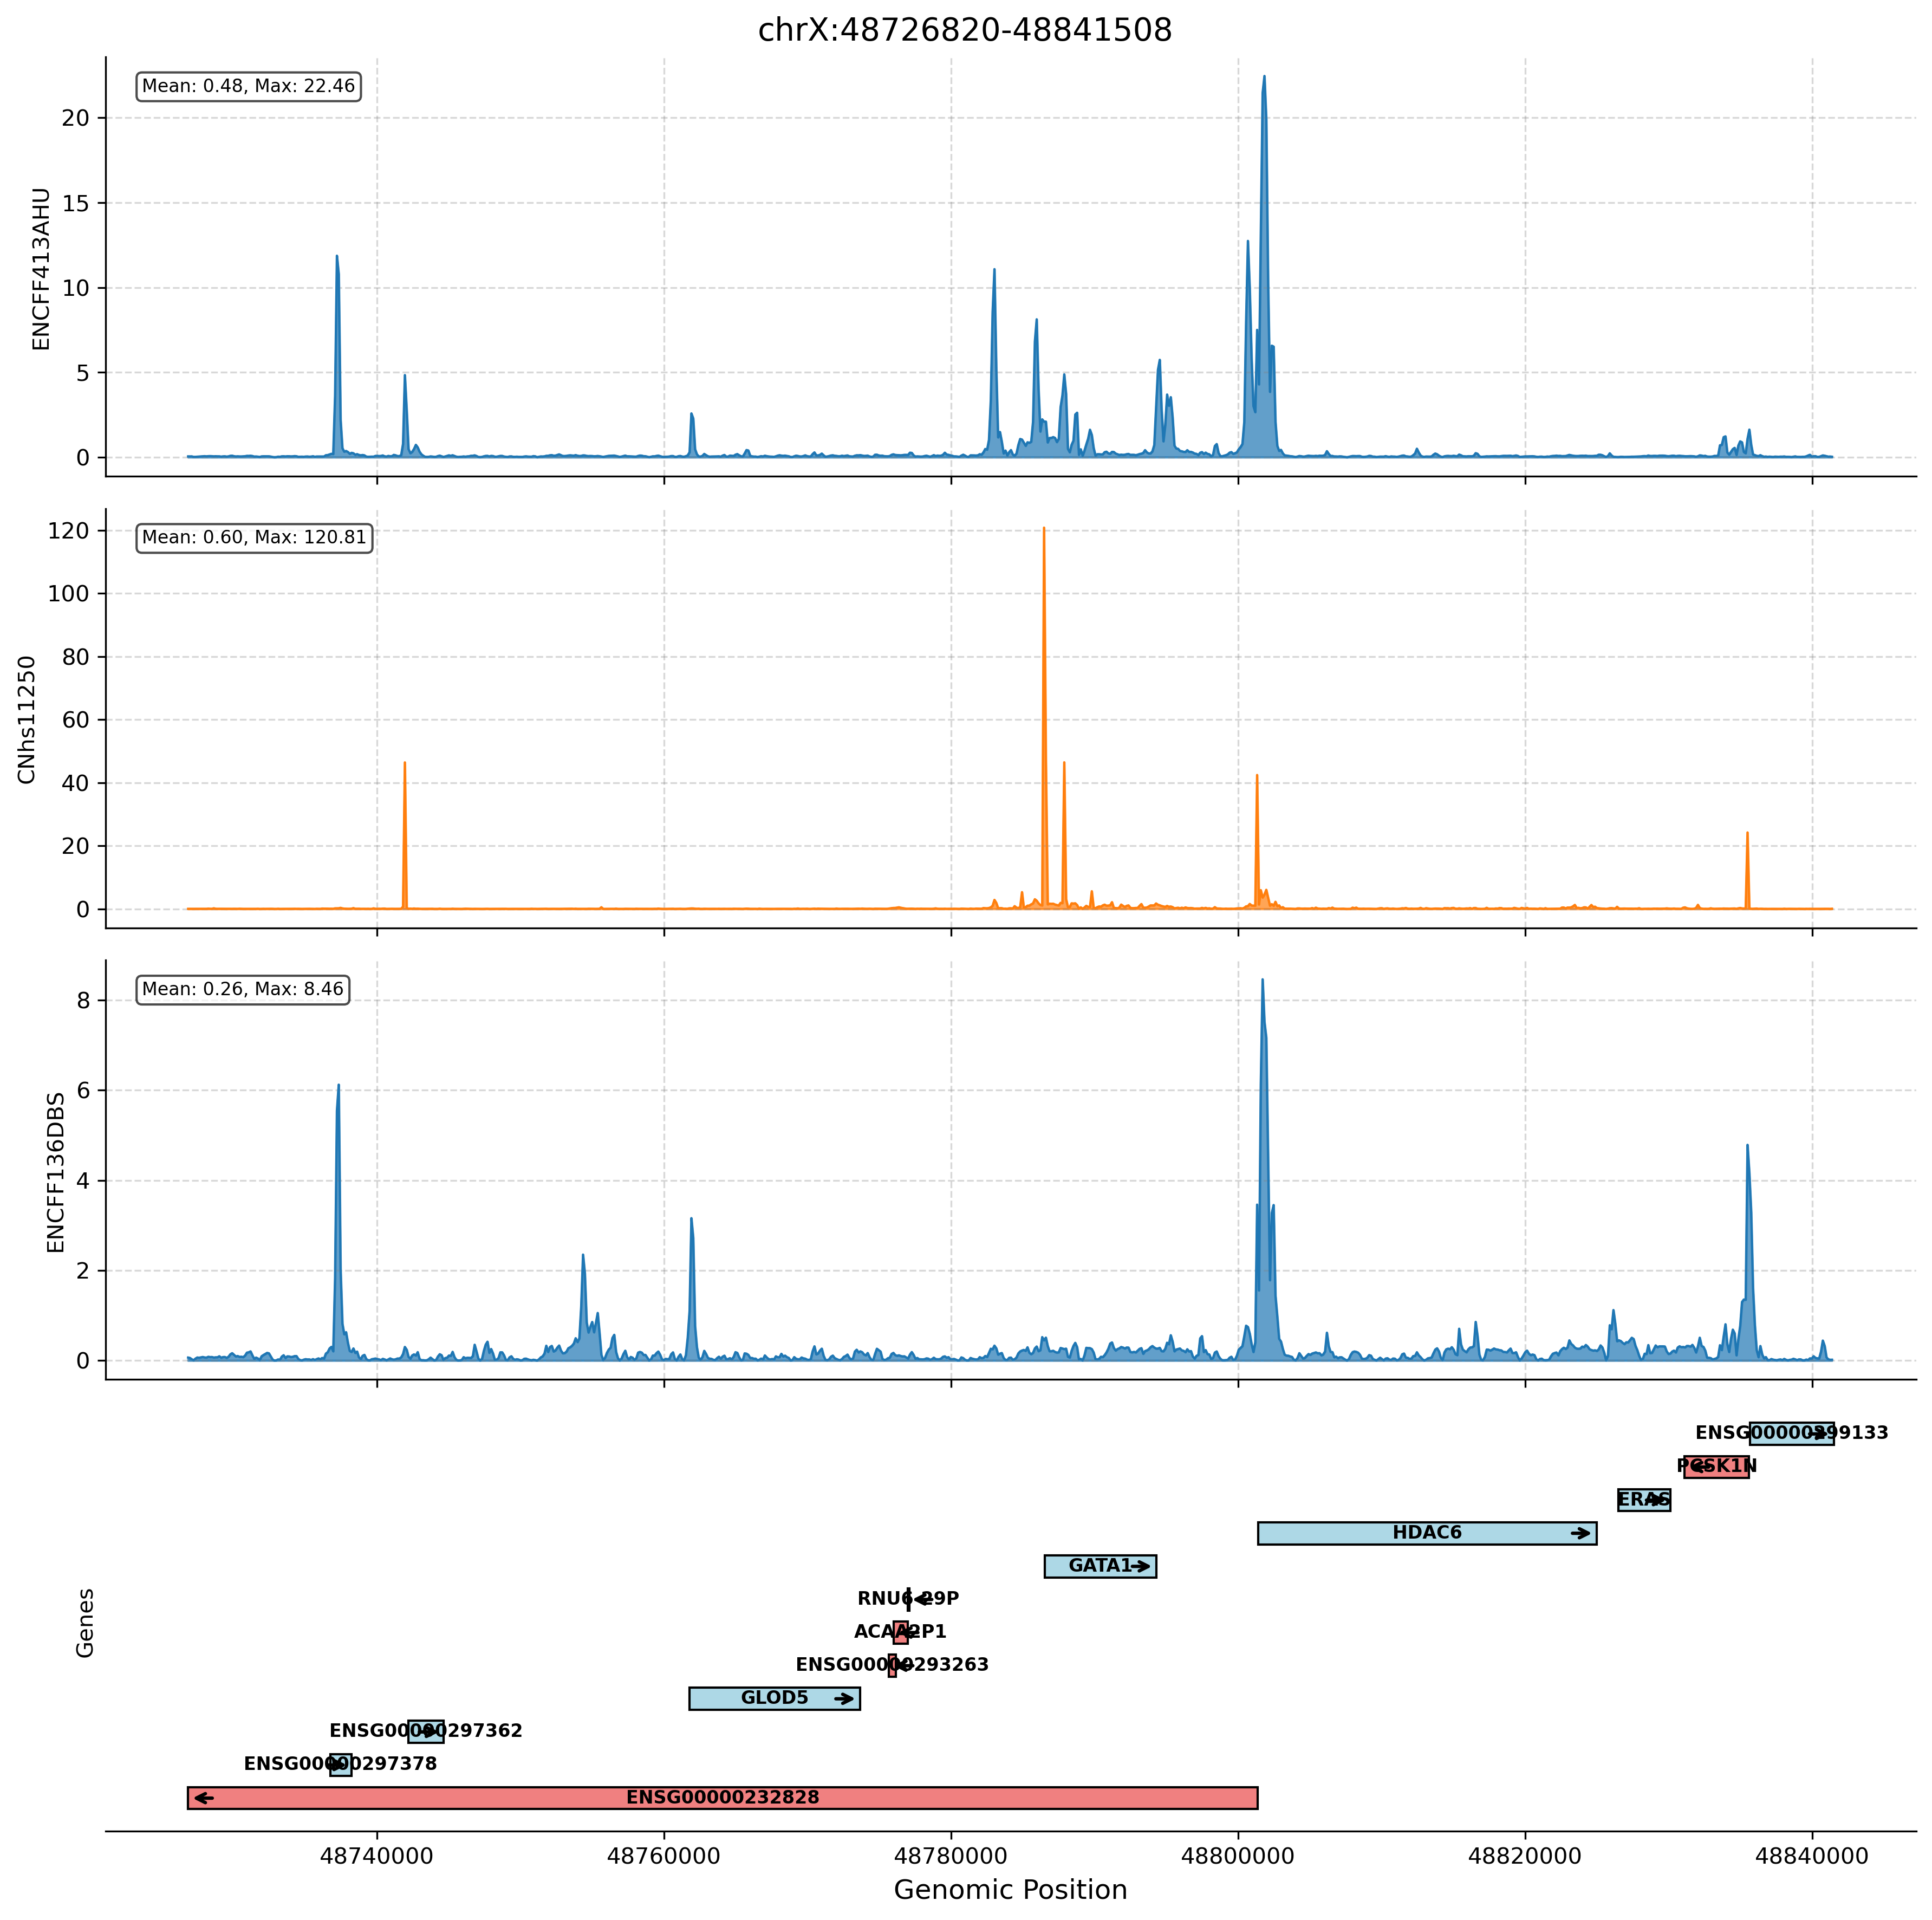

In [14]:
# For visualization, get the output window coordinates
# Create visualization with gene annotations using pyGenomeTracks
print("\nCreating visualization with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=track_ids,
        output_file='gata1_wt_with_genes.png',  # Save to file for pyGenomeTracks
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks for better gene visualization
    )
    print("Saved visualization to: gata1_wt_with_genes.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image('gata1_wt_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    print("Falling back to matplotlib visualization...")
    
    # Fallback to matplotlib for inline display
    visualize_chorus_predictions(
        predictions=wt_results,
        track_ids=track_ids,
        output_file=None,  # Display inline
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )
finally:
    pass

## Gene Expression Analysis

Let's analyze the predicted GATA1 expression using CAGE signal at TSS positions.

Getting TSS positions for GATA1...

Found 6 transcripts for GATA1:
  - ENST00000696450.1 (protein_coding) TSS at chrX:48786540 (+)
  - ENST00000651144.2 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000696451.1 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000696452.1 (protein_coding) TSS at chrX:48786562 (+)
  - ENST00000376665.4 (protein_coding) TSS at chrX:48786573 (+)

Analyzing GATA1 expression from predictions...

GATA1 Expression Analysis:
  Number of TSS in region: 6
  TSS positions in output window: [48786540, 48786562, 48786562, 48786562, 48786573, 48786590]

  Predicted CAGE expression:
    CNhs11250: mean=120.81, max=120.81


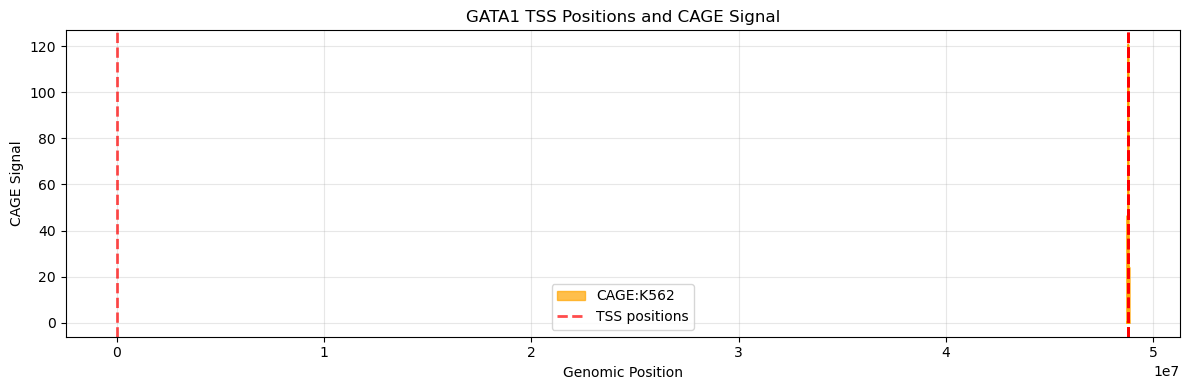

In [14]:
# Analyze GATA1 gene expression using CAGE predictions
from chorus.utils import get_gene_tss
from chorus.core.result import analyze_gene_expression

# Get TSS information for GATA1
print("Getting TSS positions for GATA1...")
gata1_tss = get_gene_tss('GATA1')
print(f"\nFound {len(gata1_tss)} transcripts for GATA1:")
for _, tss in gata1_tss.head(5).iterrows():
    print(f"  - {tss['transcript_id']} ({tss['transcript_type']}) TSS at {tss['chrom']}:{tss['tss']} ({tss['strand']})")

# Analyze expression at TSS
print("\nAnalyzing GATA1 expression from predictions...")
expression_analysis = analyze_gene_expression(
    predictions=wt_results,
    gene_name='GATA1',
    gtf_file=str(gtf_path),
    cage_track_ids=['CNhs11250']  # Focus on CAGE track
)

print(f"\nGATA1 Expression Analysis:")
print(f"  Number of TSS in region: {expression_analysis['n_tss']}")
print(f"  TSS positions in output window: {expression_analysis['tss_positions']}")
print(f"\n  Predicted CAGE expression:")
for track_id, mean_expr in expression_analysis['mean_expression'].items():
    max_expr = expression_analysis['max_expression'][track_id]
    print(f"    {track_id}: mean={mean_expr:.2f}, max={max_expr:.2f}")

# Visualize TSS locations
if expression_analysis['tss_positions']:
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Plot CAGE signal
    cage_predictions = wt_results['CNhs11250']
    positions = cage_predictions.positions
    
    ax.fill_between(positions, cage_predictions.values, alpha=0.7, color='orange', label='CAGE:K562')
    ax.plot(positions, cage_predictions, color='orange', linewidth=1)
    
    # Mark TSS positions
    for tss_pos in expression_analysis['tss_positions']:
        ax.axvline(x=tss_pos, color='red', linestyle='--', alpha=0.7, linewidth=2)
    
    # Add dummy line for legend
    ax.axvline(x=-1, color='red', linestyle='--', alpha=0.7, linewidth=2, label='TSS positions')
    
    ax.set_xlabel('Genomic Position')
    ax.set_ylabel('CAGE Signal')
    ax.set_title('GATA1 TSS Positions and CAGE Signal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## Example B: Region Replacement

Replace a sub-region with a synthetic sequence and analyze the effects.

In [15]:
# Define replacement parameters
replace_region = "chrX:48782929-48783129"
replacement_seq = "CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCAAAGGCGACACCCAACATGTGCGTGCTTGAGATAATGACTAAAAACTGCCCGTGACTCAAGCGCTTCTGGTGAGGGAAGATAAGGCAAGGAAACTGGCCGCCTAGATAGCCCTGGGAATGAGGCAGTCTCTGTTCTGGGTAAAGTGTCTGC"

print(f"Replacing region: {replace_region}")
print(f"Original region length: 200 bp")
print(f"Replacement sequence length: {len(replacement_seq)} bp")
print(f"\nReplacement sequence (first 50 bp): {replacement_seq[:50]}...")

Replacing region: chrX:48782929-48783129
Original region length: 200 bp
Replacement sequence length: 200 bp

Replacement sequence (first 50 bp): CTGCTTGCTTTAGCTTCAGGGTTCTTATCTTTTTTCATTTTATAACAGCA...


In [16]:
# Make predictions with replacement
print("Making predictions with replaced region...\n")
replacement_results = oracle.predict_region_replacement(
    genomic_region=replace_region,
    seq=replacement_seq,
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

# Analyze changes
print("Signal changes due to replacement:")
for track_id in track_ids:
    predictions = replacement_results['normalized_scores'][track_id]
    print(f"\n{track_id}:")
    print(f"  Mean signal: {np.mean(predictions.values):.4f}")
    print(f"  Max signal: {np.max(predictions.values):.4f}")

Making predictions with replaced region...

Signal changes due to replacement:

ENCFF413AHU:
  Mean signal: 0.0234
  Max signal: 1.0000

CNhs11250:
  Mean signal: 0.0045
  Max signal: 1.0000



Saving replacement tracks...
Saved 2 files

Visualizing replacement effects with gene annotations...
Saved visualization to: replacement_with_genes.png


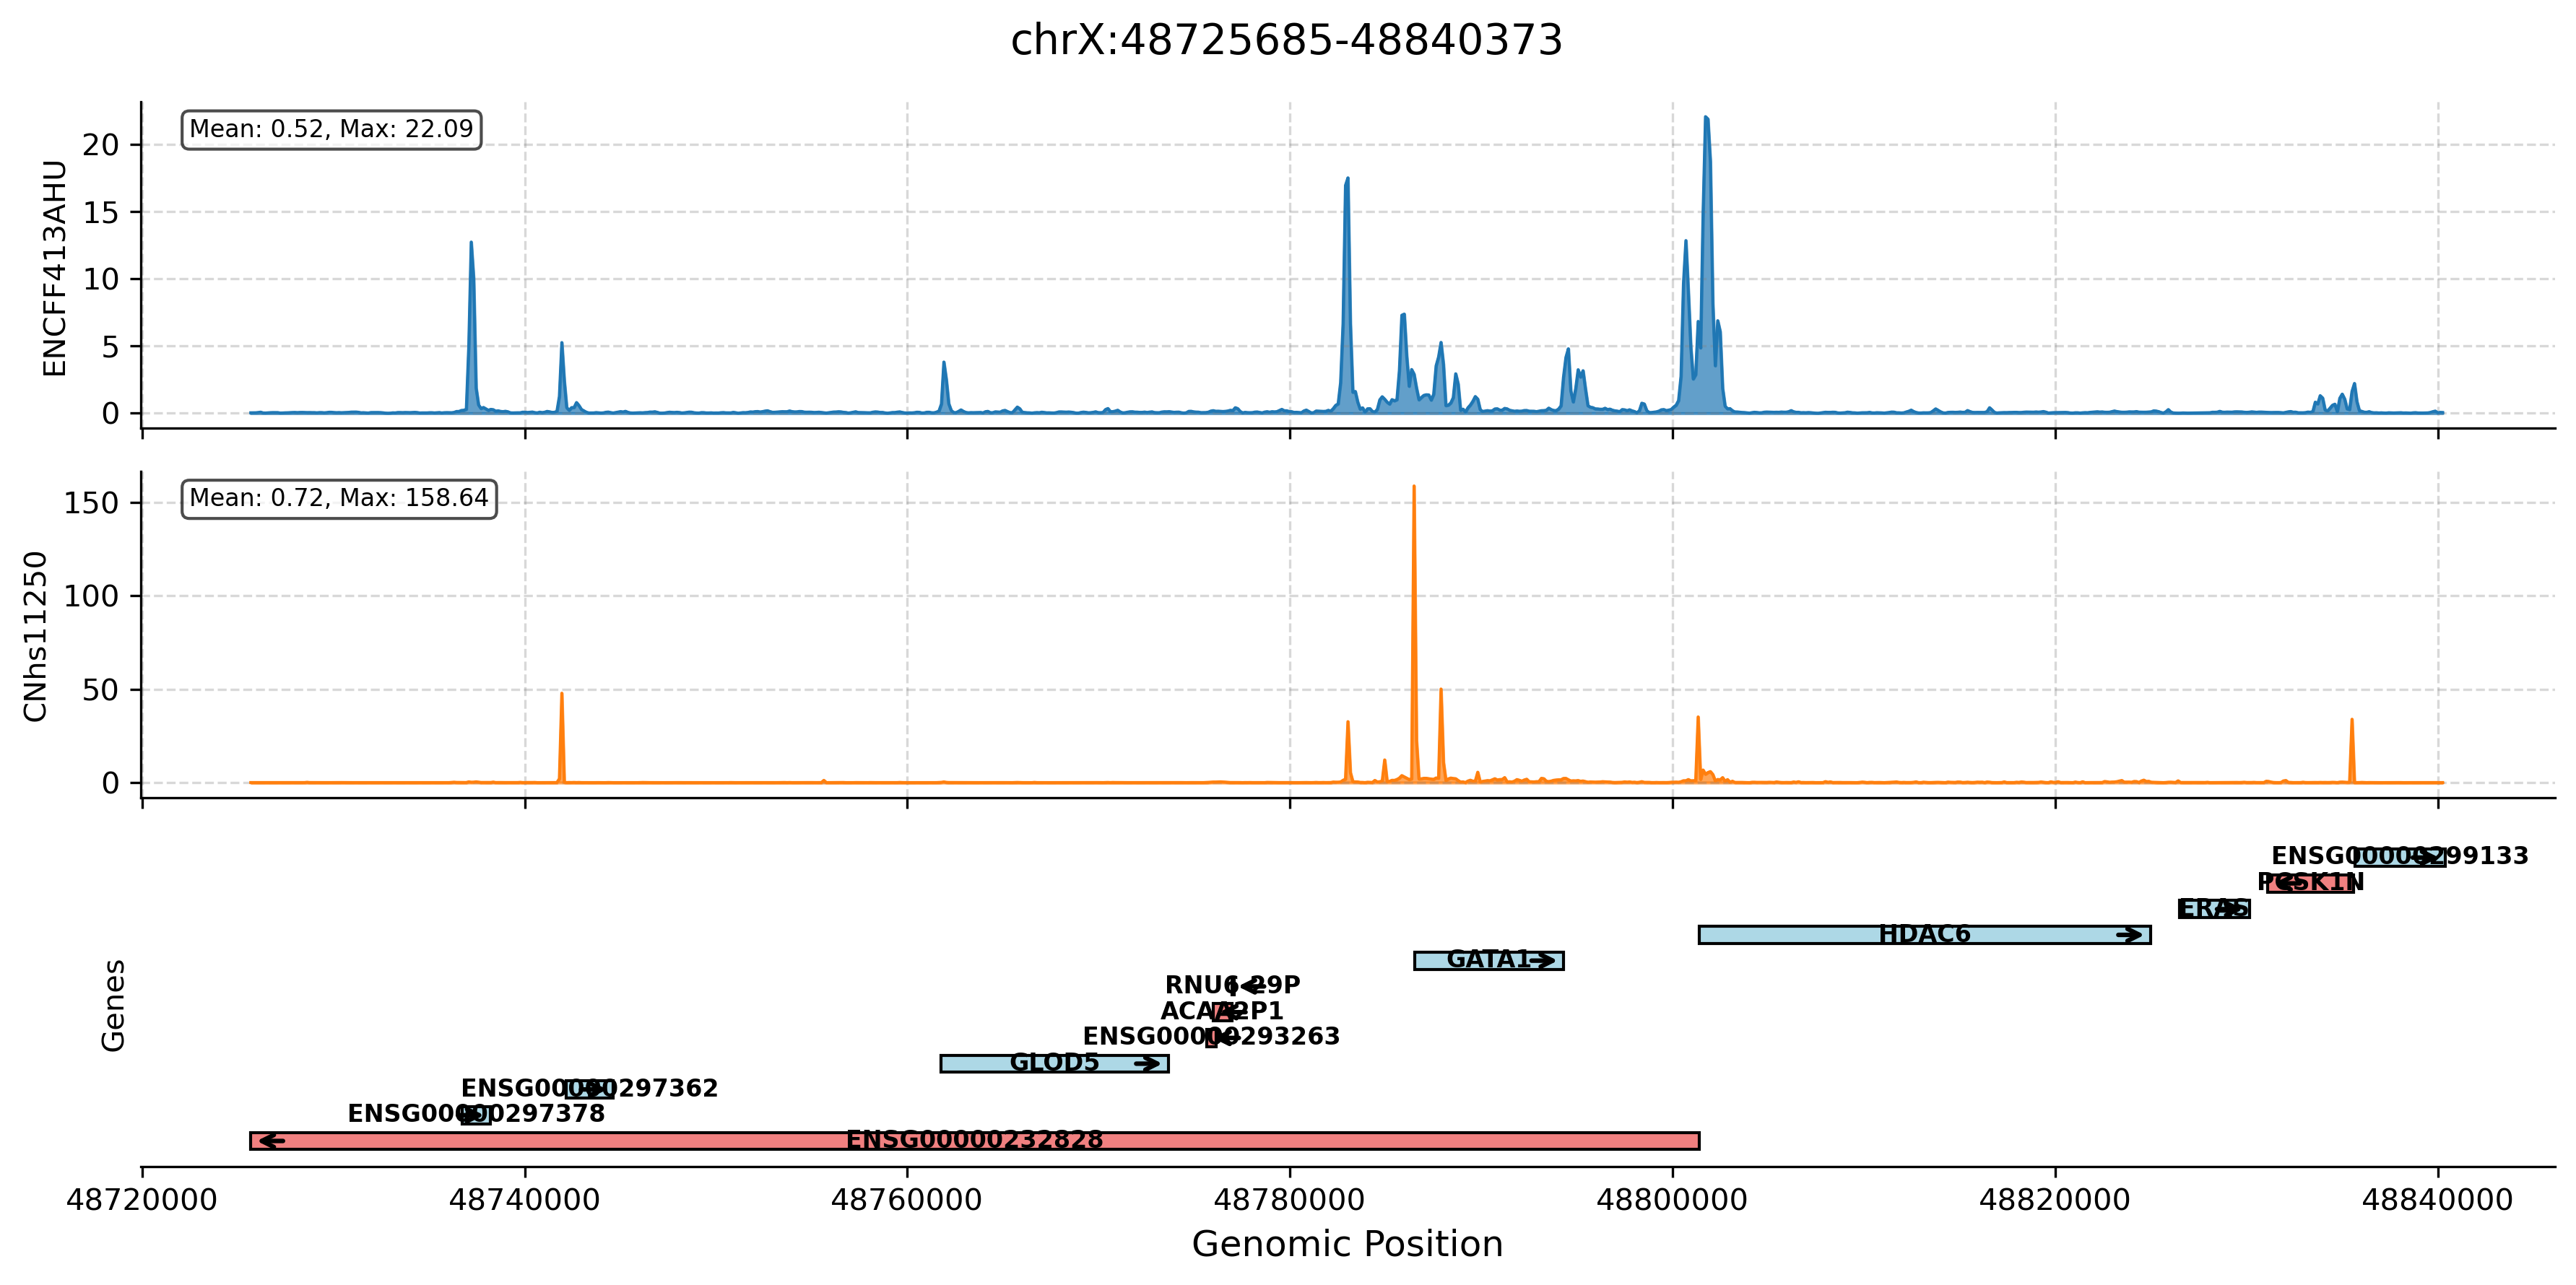

In [17]:
# Save replacement tracks and visualize
print("\nSaving replacement tracks...")

replacement_files = replacement_results['raw_predictions'].save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix='b_replacement'
)
print(f"Saved {len(replacement_files)} files")

# Visualize replacement results with gene annotations
print("\nVisualizing replacement effects with gene annotations...")
try:
    visualize_chorus_predictions(
        predictions=replacement_results['raw_predictions'],
        track_ids=track_ids,
        output_file='replacement_with_genes.png',
        figsize=(12, 6),
        gtf_file=str(gtf_path),  # Add gene annotations
        use_pygenometracks=False  # Use pyGenomeTracks
    )
    print("Saved visualization to: replacement_with_genes.png")
    from IPython.display import Image, display
    display(Image('replacement_with_genes.png', width=800))
except:
    # Fallback to matplotlib
    visualize_chorus_predictions(
        predictions=replacement_results['raw_predictions'],
        track_ids=track_ids,
        output_file=None,
        figsize=(12, 6),
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )

## Example C: Sequence Insertion

Insert the same sequence at a different position to see how location affects predictions.

In [18]:
# Define insertion parameters
insertion_pos = "chrX:48781929"
insert_seq = replacement_seq  # Use same sequence as before

print(f"Inserting at position: {insertion_pos}")
print(f"Insert sequence length: {len(insert_seq)} bp")
print("This insertion is ~1kb upstream of the replacement position")

Inserting at position: chrX:48781929
Insert sequence length: 200 bp
This insertion is ~1kb upstream of the replacement position


In [19]:
# Make predictions with insertion
print("\nMaking predictions with insertion...\n")
insertion_results = oracle.predict_region_insertion_at(
    genomic_position=insertion_pos,
    seq=insert_seq,
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)



Making predictions with insertion...



In [20]:
# Analyze impact around insertion site
print("Impact of insertion:")
for track_id in track_ids:
    predictions = insertion_results['normalized_scores'][track_id]
    # Center of output is where insertion occurs
    center = len(predictions.values) // 2
    window = 20
    local_signal = predictions.values[center-window:center+window]
    
    print(f"\n{track_id}:")
    print(f"  Overall mean: {np.mean(predictions.values):.4f}")
    print(f"  Signal around insertion: {np.mean(local_signal):.4f}")
    print(f"  Peak near insertion: {np.max(local_signal):.4f}")

Impact of insertion:

ENCFF413AHU:
  Overall mean: 0.0247
  Signal around insertion: 0.0919
  Peak near insertion: 0.6682

CNhs11250:
  Overall mean: 0.0057
  Signal around insertion: 0.0108
  Peak near insertion: 0.2116


Visualizing insertion effects...

Saving insertion tracks...
Saved 2 files


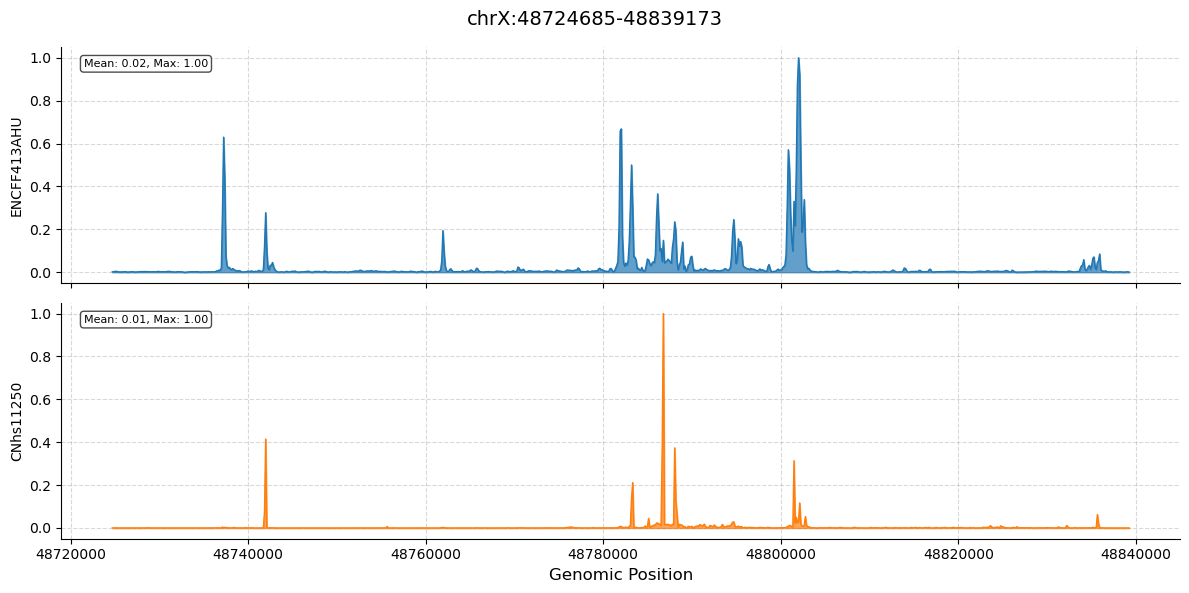

In [21]:
# Visualize insertion effects with improved plotting
print("Visualizing insertion effects...")

# Save insertion tracks first
print("\nSaving insertion tracks...")

insertion_files =insertion_results['raw_predictions'].save_predictions_as_bedgraph(
    output_dir="bedgraph_outputs",
    prefix='c_insertion'
)

print(f"Saved {len(insertion_files)} files")

visualize_chorus_predictions(
        predictions= insertion_results['normalized_scores'],
        track_ids=track_ids,
        output_file=None,)


Creating full insertion visualization...
Saved full insertion visualization to: insertion_full_with_genes.png


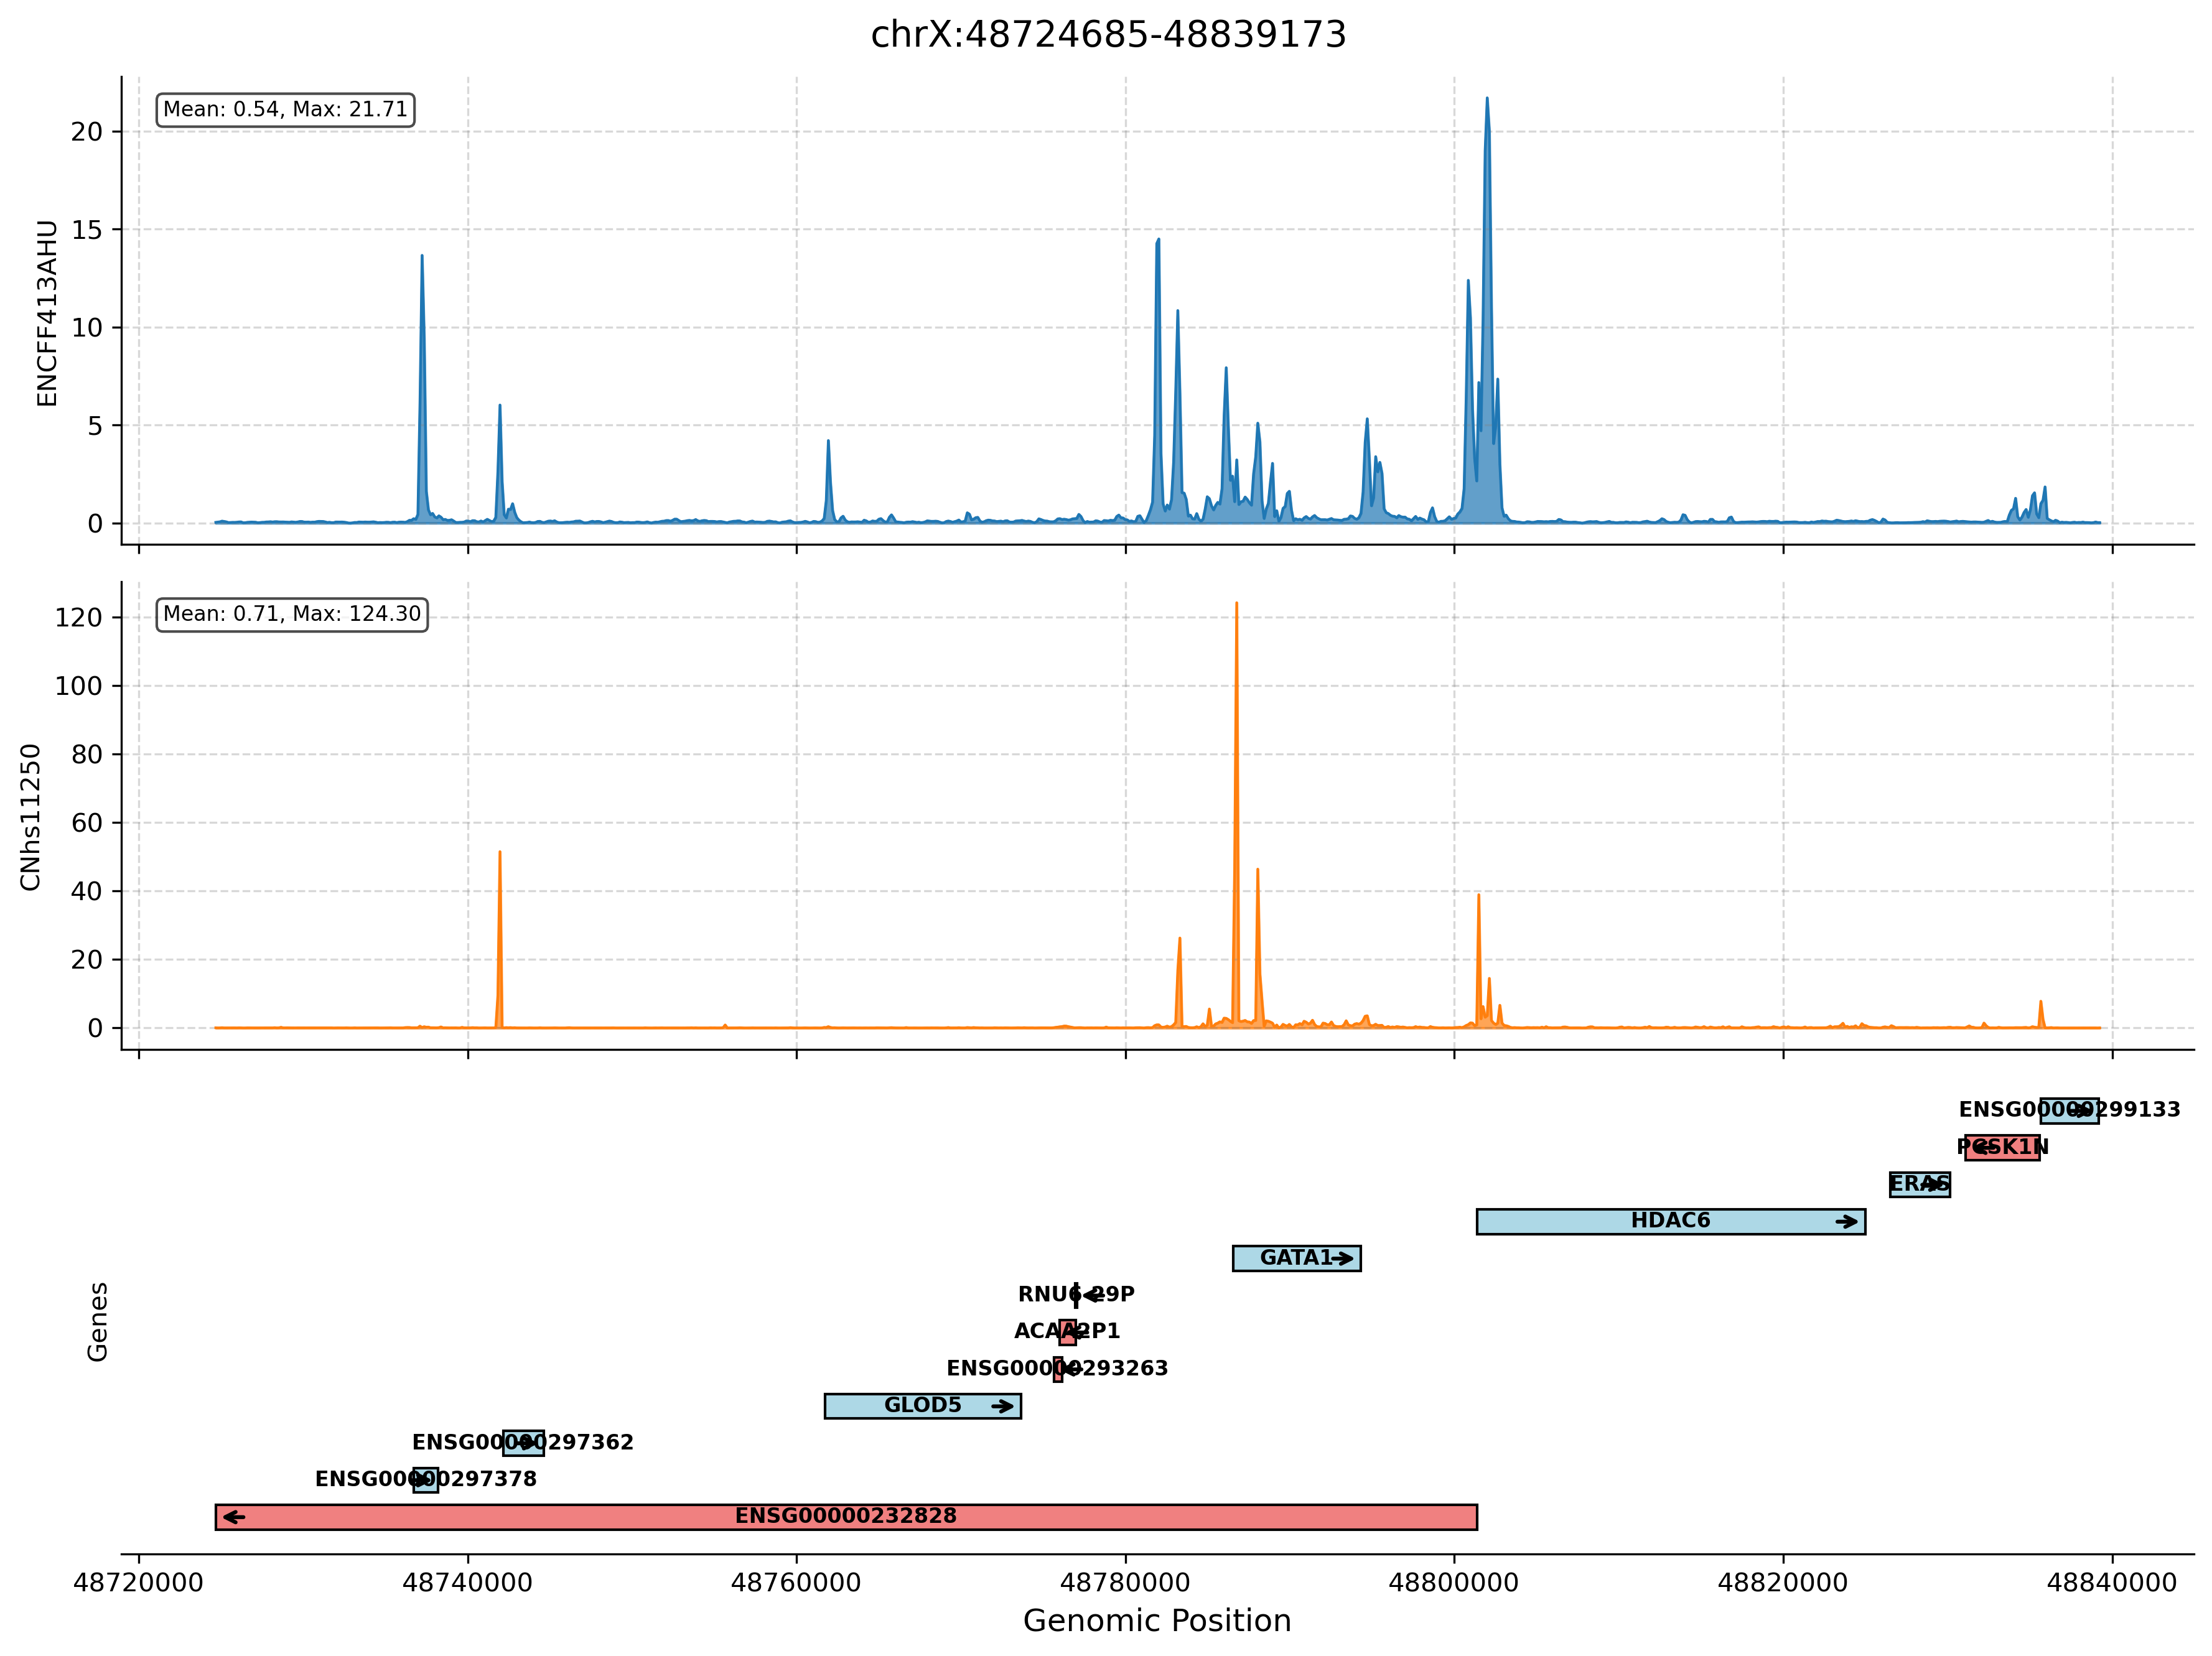

In [22]:
# Create a full visualization of insertion results with pyGenomeTracks
print("Creating full insertion visualization...")

try:
    # Get full predictions for visualization
    full_insertion_predictions = insertion_results['raw_predictions']
    
    # Save and visualize with pyGenomeTracks
    visualize_chorus_predictions(
        predictions=full_insertion_predictions,
        track_ids=track_ids,
        output_file='insertion_full_with_genes.png',
        gtf_file=str(gtf_path),
        use_pygenometracks=False#
    )
    print("Saved full insertion visualization to: insertion_full_with_genes.png")
    
    from IPython.display import Image, display
    display(Image('insertion_full_with_genes.png', width=800))
    
except Exception as e:
    print(f"Could not create pyGenomeTracks visualization: {e}")
    
    # Fallback: save matplotlib version
    visualize_chorus_predictions(
        predictions=full_insertion_predictions,
        track_ids=track_ids,
        output_file='insertion_full_matplotlib_with_genes.png',
        gtf_file=str(gtf_path),
        use_pygenometracks=False
    )
    print("Saved matplotlib version to: insertion_full_matplotlib.png")

## Example D: Variant Effect Analysis

Test the effect of single nucleotide polymorphisms (SNPs) at a specific position.

In [37]:
# Define variant to test
variant_pos = 48786129
ref_seq = 'C'  # Corrected reference allele from 'G' to 'C'

print(f"Testing variant at chrX:{variant_pos}")
print(f"Reference allele: {ref_seq}")

# Create alleles list with reference first, then alternatives
alt_alleles = [a for a in ['A', 'C', 'G', 'T'] if a != ref_seq]
test_alleles = [ref_seq] + alt_alleles  # Reference first, then alternatives

print(f"Testing substitutions: {ref_seq} -> {', '.join(alt_alleles)}")

# Need a wider region for variant analysis
print("\nPredicting variant effects...\n")
variant_results = oracle.predict_variant_effect(
    genomic_region=f"chrX:{variant_pos-5000}-{variant_pos+5000}",
    variant_position=f"chrX:{variant_pos}",
    alleles=test_alleles,  # Reference first, then alternatives
    assay_ids=track_ids,  # Using specific track IDs
    genome=str(genome_path)
)

print("\nVariant predictions completed!")

Testing variant at chrX:48786129
Reference allele: C
Testing substitutions: C -> A, G, T

Predicting variant effects...


Variant predictions completed!


In [38]:
# Analyze variant effects
print("Variant effect analysis:")
print("=" * 60)

# Create results dataframe
variant_effects = []

# Check the structure first
print(f"\nVariant results keys: {variant_results.keys()}")
print(f"Predictions keys: {variant_results['predictions'].keys()}")

# Get reference predictions - it's a dictionary, not a 2D array
ref_predictions = variant_results['predictions']['reference']
print(f"\nReference predictions type: {type(ref_predictions)}")
if isinstance(ref_predictions, dict):
    print(f"Track IDs in predictions: {list(ref_predictions.keys())}")

for track_id in track_ids:
    # Get reference signal for this track
    ref_signal = np.mean(ref_predictions[track_id].values)
    
    print(f"\n{track_id}:")
    print(f"  Reference ({ref_seq}) mean signal: {ref_signal:.4f}")
    print("  Variant effects:")
    
    # Add reference to dataframe
    variant_effects.append({
        'Track': track_id,
        'Allele': ref_seq,
        'Signal': ref_signal,
        'Effect': 0.0,
        'Is_Reference': True
    })
    
    # Add alternatives
    for i, allele in enumerate(alt_alleles):
        allele_key = f'alt_{i+1}'
        if allele_key in variant_results['predictions']:
            alt_predictions = variant_results['predictions'][allele_key]
            alt_signal = np.mean(alt_predictions[track_id].values)
            effect = alt_signal - ref_signal
            print(f"    {allele}: {alt_signal:.4f} (Δ = {effect:+.4f})")
            
            variant_effects.append({
                'Track': track_id,
                'Allele': allele,
                'Signal': alt_signal,
                'Effect': effect,
                'Is_Reference': False
            })

# Create DataFrame for easier analysis
variant_df = pd.DataFrame(variant_effects)
variant_df

Variant effect analysis:

Variant results keys: dict_keys(['predictions', 'effect_sizes', 'variant_info'])
Predictions keys: dict_keys(['reference', 'alt_1', 'alt_2', 'alt_3'])

Reference predictions type: <class 'chorus.core.result.OraclePrediction'>

ENCFF413AHU:
  Reference (C) mean signal: 0.4467
  Variant effects:
    A: 0.4463 (Δ = -0.0004)
    G: 0.4458 (Δ = -0.0010)
    T: 0.4455 (Δ = -0.0012)

CNhs11250:
  Reference (C) mean signal: 0.5401
  Variant effects:
    A: 0.5371 (Δ = -0.0030)
    G: 0.5329 (Δ = -0.0072)
    T: 0.5346 (Δ = -0.0055)


,Track,Allele,Signal,Effect,Is_Reference
0,ENCFF413AHU,C,0.446733,0.000000,True
1,ENCFF413AHU,A,0.446308,-0.000425,False
2,ENCFF413AHU,G,0.445779,-0.000954,False
3,ENCFF413AHU,T,0.445505,-0.001228,False
4,CNhs11250,C,0.540126,0.000000,True
5,CNhs11250,A,0.537084,-0.003042,False
6,CNhs11250,G,0.532894,-0.007232,False
7,CNhs11250,T,0.534630,-0.005496,False


Creating detailed variant comparison...
Reference predictions type: <class 'chorus.core.result.OraclePrediction'>
Prediction shape for each track: (896,)
Variant position 48786129 is at bin 448 in the output


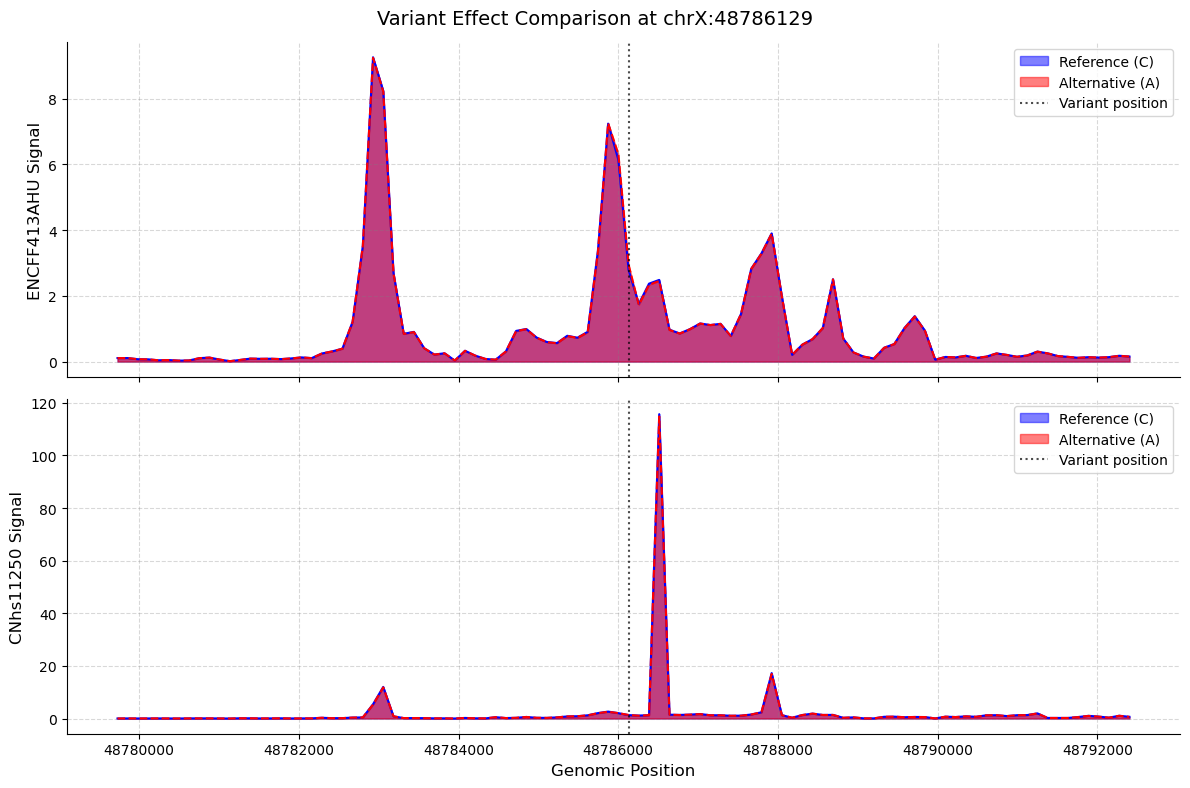

In [48]:
# Create a detailed variant comparison visualization
print("Creating detailed variant comparison...")

# First, let's check the shape of the predictions
ref_predictions = variant_results['predictions']['reference']
print(f"Reference predictions type: {type(ref_predictions)}")

# Get the shape from one of the tracks
ref_shape = ref_predictions[track_ids[0]].values.shape
print(f"Prediction shape for each track: {ref_shape}")

# The predictions are for the full output window (896 bins)
# We need to find where the variant position falls within this window

# Get the genomic coordinates of the output window
variant_region_center = variant_pos  # Since we used a region centered on the variant
track = next(iter(variant_results['predictions']['reference'].values()))
interval = track.prediction_interval
output_start, output_end = interval.reference.start,  interval.reference.end

# Calculate where the variant falls in the output
variant_bin = (variant_pos - output_start) //  track.resolution
print(f"Variant position {variant_pos} is at bin {variant_bin} in the output")

# Focus on a window around the variant
variant_window_size = 50  # bins on each side
window_start = max(0, variant_bin - variant_window_size)
window_end = min(ref_shape[0], variant_bin + variant_window_size)

# Create comparison plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, facecolor='white')

for idx, (track_id, ax) in enumerate(zip(track_ids, axes)):
    # Plot reference - access by track_id
    ref_values = variant_results['predictions']['reference'][track_id].values[window_start:window_end]
    positions = np.arange(len(ref_values)) * track.resolution + output_start + window_start * track.resolution
    ax.fill_between(positions, ref_values, alpha=0.5, color='blue', label=f'Reference ({ref_seq})')
    ax.plot(positions, ref_values, color='blue', linewidth=1.5)
    
    # Plot first alternative
    alt_values = variant_results['predictions']['alt_1'][track_id].values[window_start:window_end]
    ax.fill_between(positions, alt_values, alpha=0.5, color='red', label=f'Alternative ({alt_alleles[0]})')
    ax.plot(positions, alt_values, color='red', linewidth=1.5, linestyle='--')
    
    # Mark variant position
    ax.axvline(x=variant_pos, color='black', linestyle=':', alpha=0.7, label='Variant position')
    
    ax.set_ylabel(f'{track_id} Signal', fontsize=12)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax.set_facecolor('white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[-1].set_xlabel('Genomic Position', fontsize=12)
axes[-1].ticklabel_format(style='plain', axis='x')
fig.suptitle(f'Variant Effect Comparison at chrX:{variant_pos}', fontsize=14)
plt.tight_layout()

# Display the figure
from IPython.display import display
display(fig)
plt.close()  # Close to free memory

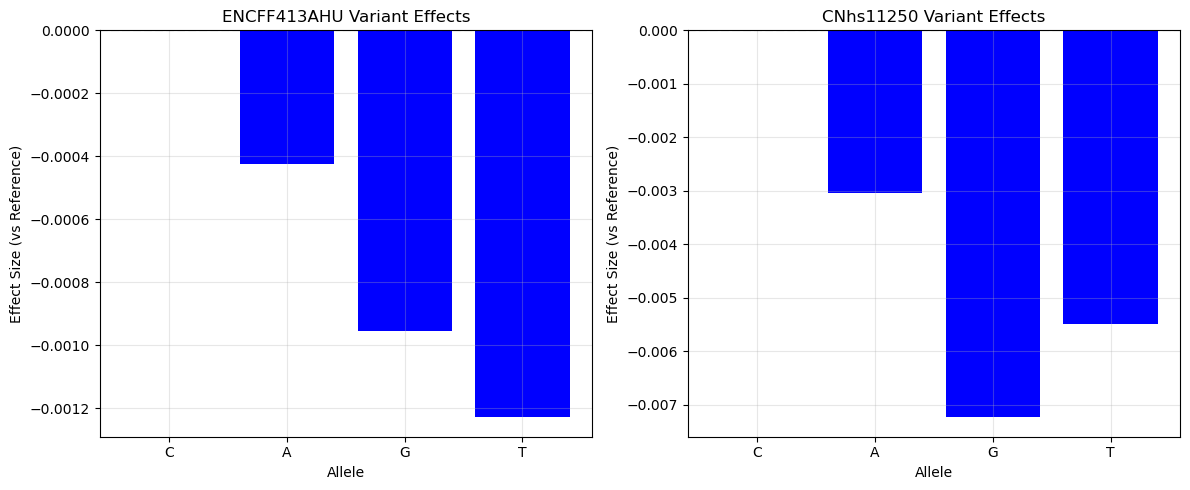

In [49]:
# Visualize variant effects as bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for idx, track_id in enumerate(track_ids):
    track_data = variant_df[variant_df['Track'] == track_id]
    
    colors = ['red' if is_ref else 'blue' 
              for is_ref in track_data['Is_Reference']]
    
    axes[idx].bar(track_data['Allele'], track_data['Effect'], color=colors)
    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[idx].set_title(f"{track_id} Variant Effects")
    axes[idx].set_xlabel('Allele')
    axes[idx].set_ylabel('Effect Size (vs Reference)')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
# Display the figure
from IPython.display import display
display(fig)
plt.close()



## Example E: Direct Sequence Prediction

Demonstrate prediction on a synthetic sequence without genomic coordinates.

In [7]:
# Create a synthetic sequence with known regulatory elements
print("Creating synthetic sequence with regulatory elements...\n")

# Enformer requires exactly 393,216 bp
context_size = oracle.sequence_length

# Define regulatory elements
promoter_elements = {
    'TATA_box': 'TATAAA',
    'CAAT_box': 'CCAAT',
    'GC_box': 'GGGCGG',
    'GATA_motif': 'GATA',
    'E_box': 'CACGTG'
}

print("Regulatory elements used:")
for name, seq in promoter_elements.items():
    print(f"  {name}: {seq}")

Creating synthetic sequence with regulatory elements...

Regulatory elements used:
  TATA_box: TATAAA
  CAAT_box: CCAAT
  GC_box: GGGCGG
  GATA_motif: GATA
  E_box: CACGTG


In [8]:
# Build synthetic sequence
print("\nBuilding synthetic sequence...")
seq_parts = []
element_positions = []

for i in range(0, context_size, 1000):
    if i % 5000 == 0:
        # Add strong promoter every 5kb
        motifs = ''.join([
            promoter_elements['TATA_box'],
            'N' * 20,
            promoter_elements['CAAT_box'],
            'N' * 50,
            promoter_elements['GC_box']
        ])
        seq_parts.append(motifs)
        element_positions.append((i, 'promoter'))
    elif i % 3000 == 0:
        # Add enhancer elements
        enhancer = (promoter_elements['GATA_motif'] + 'NNNN') * 5
        seq_parts.append(enhancer)
        element_positions.append((i, 'enhancer'))
    else:
        # Random sequence
        seq_parts.append('ACGT' * 250)

# Combine and adjust to exact size
synthetic_seq = ''.join(seq_parts)[:context_size]

# Pad if needed
if len(synthetic_seq) < context_size:
    synthetic_seq += 'A' * (context_size - len(synthetic_seq))

print(f"\nFinal sequence length: {len(synthetic_seq):,} bp")
print(f"Number of promoter elements: {sum(1 for _, t in element_positions if t == 'promoter')}")
print(f"Number of enhancer elements: {sum(1 for _, t in element_positions if t == 'enhancer')}")


Building synthetic sequence...

Final sequence length: 393,216 bp
Number of promoter elements: 79
Number of enhancer elements: 105


In [9]:
# Make predictions on synthetic sequence
print("\nMaking predictions on synthetic sequence...\n")
synthetic_results = oracle.predict(
    synthetic_seq,
    track_ids  # Using specific track IDs
)

# Analyze predictions
print("Synthetic sequence predictions:")
for track_id, predictions in synthetic_results.items():
    print(f"\n{track_id}:")
    print(f"  Shape: {predictions.shape}")
    print(f"  Mean signal: {np.mean(predictions):.4f}")
    print(f"  Max signal: {np.max(predictions):.4f}")
    
    # Find top peaks
    top_bins = np.argsort(predictions)[-5:]
    print(f"  Top 5 peak bins: {top_bins}")
    print(f"  Peak values: {predictions[top_bins]}")


Making predictions on synthetic sequence...

Synthetic sequence predictions:

ENCFF413AHU:
  Shape: (896,)
  Mean signal: 0.0071
  Max signal: 0.0983
  Top 5 peak bins: [581 384 515 466 598]
  Peak values: [0.08018479 0.08137295 0.08318499 0.08851893 0.09827794]

CNhs11250:
  Shape: (896,)
  Mean signal: 0.0128
  Max signal: 0.2474
  Top 5 peak bins: [532 359 252 137 466]
  Peak values: [0.18713064 0.19077682 0.1951694  0.22750324 0.24743512]


Visualizing synthetic sequence predictions...


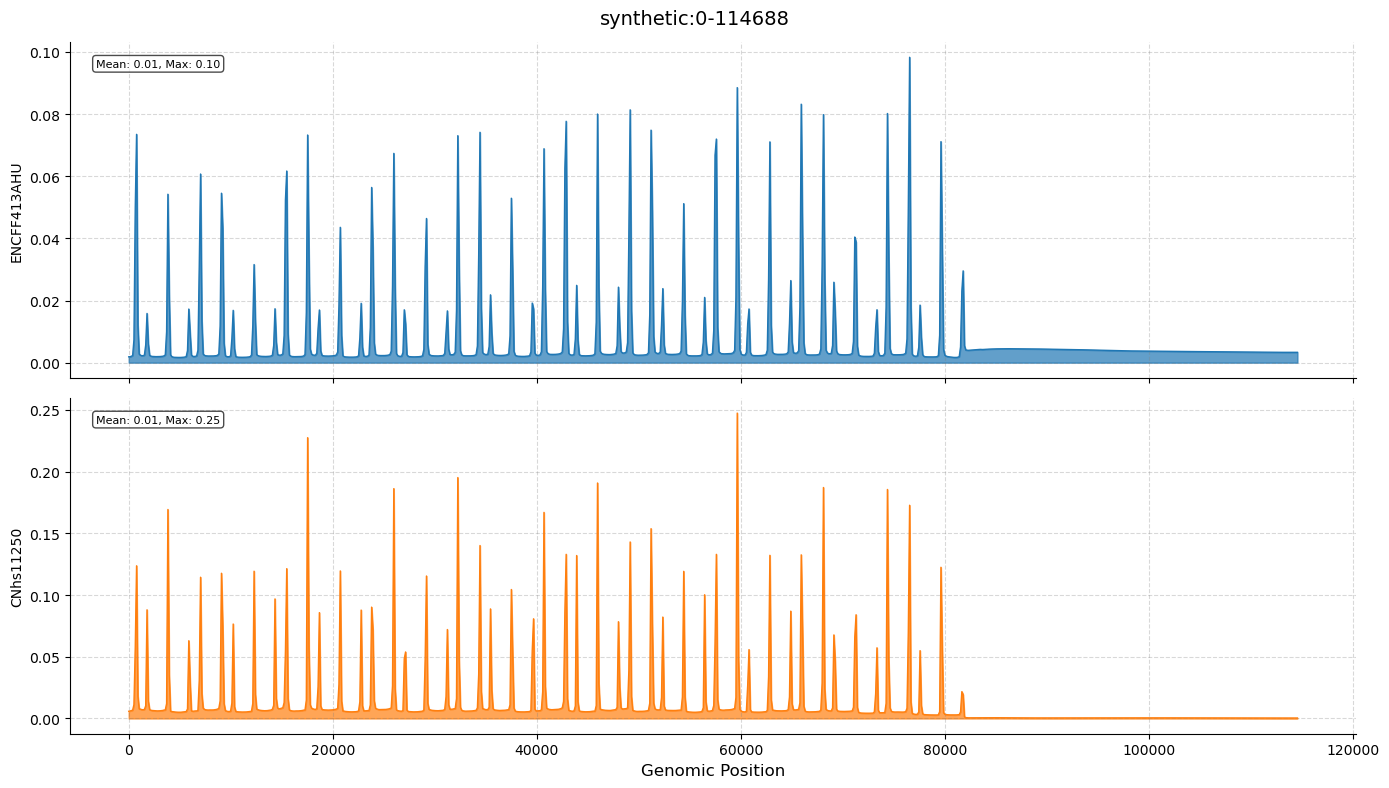


Saving synthetic sequence tracks...
Saved 2 files


In [25]:
# Visualize synthetic sequence predictions with improved plotting
print("Visualizing synthetic sequence predictions...")

visualize_chorus_predictions(
        predictions=full_insertion_predictions,
        track_ids=track_ids,
        output_file='insertion_full_matplotlib_with_genes.png',
        gtf_file=str(gtf_path),
        use_pygenometracks=False
)

# Save synthetic tracks
print("\nSaving synthetic sequence tracks...")
synthetic_files = oracle.save_predictions_as_bedgraph(
    predictions=synthetic_results,
    chrom='synthetic',
    start=0,
    output_dir="bedgraph_outputs",
    prefix='e_synthetic'
)
print(f"Saved {len(synthetic_files)} files")

In [ ]:
print("Visualizing synthetic sequence predictions...")

visualize_chorus_predictions(
        predictions=full_insertion_predictions,
        track_ids=track_ids,
        output_file='insertion_full_matplotlib_with_genes.png',
        gtf_file=str(gtf_path),
        use_pygenometracks=False
)


## Summary

In this comprehensive example, we demonstrated all major features of Chorus:

1. **Wild-type prediction**: Analyzed the GATA1 TSS region
2. **Region replacement**: Replaced a 200bp region with synthetic sequence
3. **Sequence insertion**: Inserted sequence at a different position
4. **Variant analysis**: Tested all possible SNPs at a position
5. **Direct sequence prediction**: Analyzed a fully synthetic sequence

All predictions have been saved as BedGraph files that can be loaded into genome browsers for visualization.

Visualizing synthetic sequence predictions...


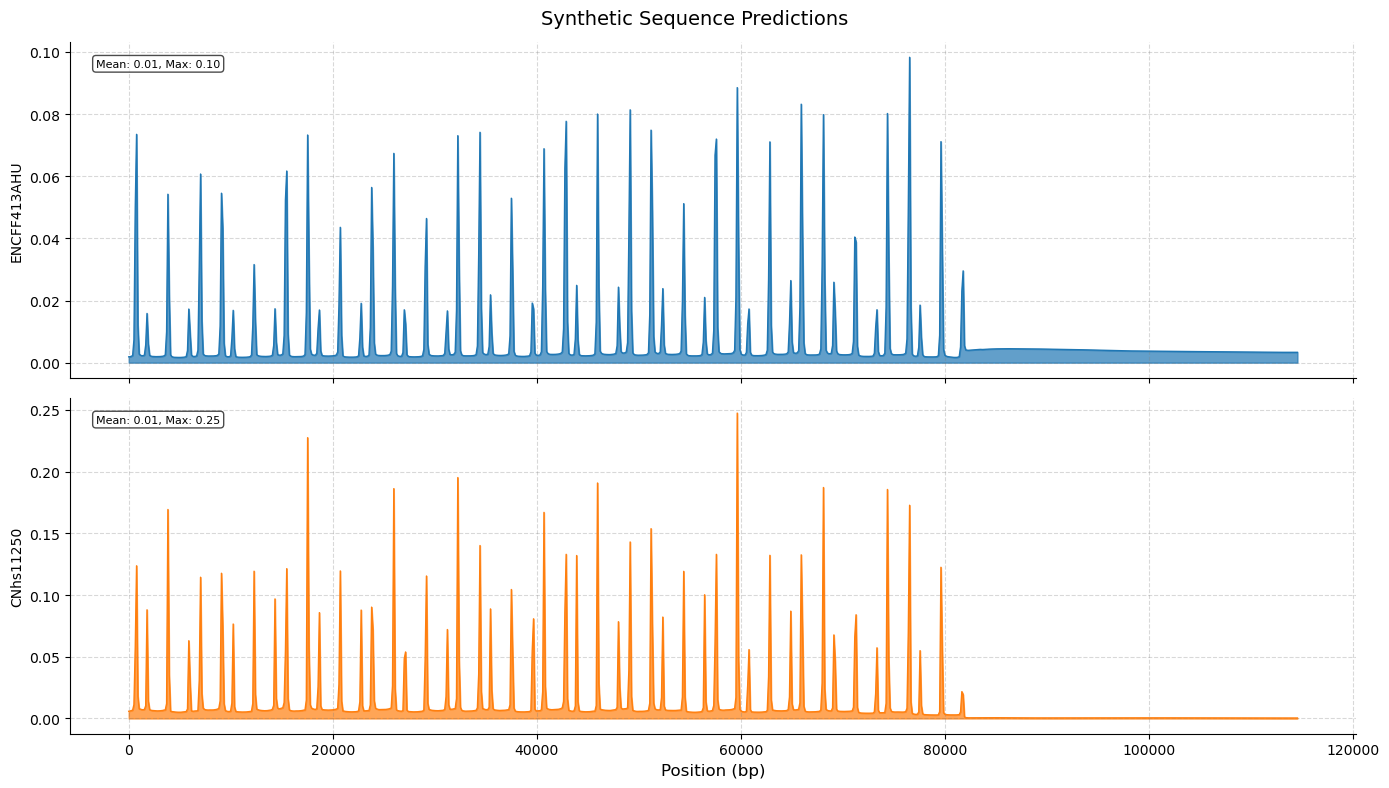


Saving synthetic sequence tracks...
Saved 2 files


In [26]:
# Visualize synthetic sequence predictions with improved plotting
print("Visualizing synthetic sequence predictions...")

# Create a custom visualization since visualize_chorus_predictions might have issues
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True, facecolor='white')

for idx, (track_id, ax) in enumerate(zip(track_ids, axes)):
    predictions = synthetic_results[track_id]
    positions = np.arange(len(predictions)) * 128
    
    # Determine track color
    if 'DNASE' in track_id.upper() or track_id.startswith('ENCFF'):
        color = '#1f77b4'  # Blue for DNase
    elif 'CAGE' in track_id.upper() or track_id.startswith('CNhs'):
        color = '#ff7f0e'  # Orange for CAGE
    else:
        color = '#9467bd'  # Purple for others
    
    # Plot
    ax.fill_between(positions, predictions, alpha=0.7, color=color)
    ax.plot(positions, predictions, color=color, linewidth=1)
    
    # Styling
    ax.set_ylabel(track_id, fontsize=10)
    ax.set_facecolor('white')
    ax.grid(True, alpha=0.3, color='gray', linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add statistics
    mean_val = np.mean(predictions)
    max_val = np.max(predictions)
    ax.text(0.02, 0.95, f'Mean: {mean_val:.2f}, Max: {max_val:.2f}',
            transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

axes[-1].set_xlabel('Position (bp)', fontsize=12)
axes[-1].ticklabel_format(style='plain', axis='x')
fig.suptitle('Synthetic Sequence Predictions', fontsize=14)
plt.tight_layout()

# Display the figure
from IPython.display import display
display(fig)
plt.close()

# Save synthetic tracks
print("\nSaving synthetic sequence tracks...")
synthetic_files = oracle.save_predictions_as_bedgraph(
    predictions=synthetic_results,
    chrom='synthetic',
    start=0,
    output_dir="bedgraph_outputs",
    prefix='e_synthetic'
)
print(f"Saved {len(synthetic_files)} files")

In [27]:
# Create comprehensive visualization with all tracks and genes
print("Creating comprehensive visualization with gene annotations...")

# Ensure we have BedGraph files for wild-type predictions
# These were already saved in Example A

# Try to create a comprehensive figure with pyGenomeTracks
try:
    from chorus.utils.visualization import plot_tracks_with_pygenometracks
    import os
    
    # Get list of bedgraph files (if they exist)
    bedgraph_files = []
    if os.path.exists("bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph"):
        bedgraph_files.append("bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph")
    if os.path.exists("bedgraph_outputs/a_wt_CNhs11250.bedgraph"):
        bedgraph_files.append("bedgraph_outputs/a_wt_CNhs11250.bedgraph")
    
    if bedgraph_files:
        # Get output window coordinates (from Example A)
        region_center = (48777634 + 48790694) // 2
        output_start, output_end = oracle.get_output_window_coords(region_center)
        
        # Define region to visualize (focus on GATA1)
        vis_start = 48780000  # Focus on GATA1 region
        vis_end = 48800000    # 20kb window
        region_str = f"chrX:{vis_start}-{vis_end}"
        
        # Create configuration for tracks
        track_config = {
            bedgraph_files[0]: {
                'color': '#1f77b4',
                'height': 3,
                'style': 'fill',
                'title': 'DNase:K562',
                'max_value': 25
            }
        }
        
        if len(bedgraph_files) > 1:
            track_config[bedgraph_files[1]] = {
                'color': '#ff7f0e',
                'height': 3,
                'style': 'fill',
                'title': 'CAGE:K562',
                'max_value': 150
            }
        
        # Create the plot with gene annotations
        success = plot_tracks_with_pygenometracks(
            track_files=bedgraph_files,
            genomic_region=region_str,
            output_file='comprehensive_gata1_analysis.png',
            track_config=track_config,
            gtf_file=str(gtf_path),  # Include gene annotations
            width=12,
            dpi=300
        )
        
        if success:
            print(f"Saved comprehensive figure to: comprehensive_gata1_analysis.png")
            print(f"Showing region: {region_str}")
            print("This includes DNase, CAGE, and gene annotations")
            
            # Display the image
            from IPython.display import Image, display
            display(Image('comprehensive_gata1_analysis.png', width=900))
        else:
            print("Could not create pyGenomeTracks visualization.")
    else:
        print("BedGraph files not found. Please run Example A first.")
        
except Exception as e:
    print(f"Error creating comprehensive visualization: {e}")
    print("\nTo create publication-quality figures with gene tracks, install pyGenomeTracks:")
    print("  pip install pyGenomeTracks")

Creating comprehensive visualization with gene annotations...
Could not create pyGenomeTracks visualization.


/Users/lp698/Projects/chorus/chorus/utils/visualization.py:562: UserWarning: Error creating pyGenomeTracks plot: PlotTracks.__init__() got an unexpected keyword argument 'width'
  warnings.warn(f"Error creating pyGenomeTracks plot: {e}")


In [28]:
# Create comprehensive visualization with all tracks and genes
print("Creating comprehensive visualization with gene annotations...")

# Ensure we have BedGraph files for wild-type predictions
# These were already saved in Example A

# Try to create a comprehensive figure with pyGenomeTracks
try:
    from chorus.utils.visualization import plot_tracks_with_pygenometracks
    import os
    
    # Get list of bedgraph files
    bedgraph_files = [
        "bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph",
        "bedgraph_outputs/a_wt_CNhs11250.bedgraph"
    ]
    
    # Define region to visualize (use a subset of the output window)
    vis_start = output_start + 10000  # Start 10kb into the window
    vis_end = vis_start + 50000  # Show 50kb window
    region_str = f"chrX:{vis_start}-{vis_end}"
    
    # Create configuration for tracks
    track_config = {
        bedgraph_files[0]: {
            'color': '#1f77b4',
            'height': 3,
            'style': 'fill',
            'title': 'DNase:K562'
        },
        bedgraph_files[1]: {
            'color': '#ff7f0e',
            'height': 3,
            'style': 'fill',
            'title': 'CAGE:K562'
        }
    }
    
    # Create the plot
    success = plot_tracks_with_pygenometracks(
        track_files=bedgraph_files,
        genomic_region=region_str,
        output_file='comprehensive_gata1_analysis.png',
        track_config=track_config,
        gtf_file=str(gtf_path),
        width=12,
        dpi=300
    )
    
    if success:
        print(f"Saved comprehensive figure to: comprehensive_gata1_analysis.png")
        print(f"Showing region: {region_str}")
        
        # Display the image
        from IPython.display import Image, display
        display(Image('comprehensive_gata1_analysis.png'))
    else:
        print("Could not create pyGenomeTracks visualization.")
        
except Exception as e:
    print(f"Error creating comprehensive visualization: {e}")
    print("\nTo create publication-quality figures with gene tracks, install pyGenomeTracks:")
    print("  pip install pyGenomeTracks")
    print("\nUsing matplotlib visualization instead...")

Creating comprehensive visualization with gene annotations...
Could not create pyGenomeTracks visualization.


Creating comprehensive visualization with gene annotations...
Found 2 BedGraph files

Creating matplotlib visualization...
Saved comprehensive figure to: comprehensive_gata1_matplotlib.png


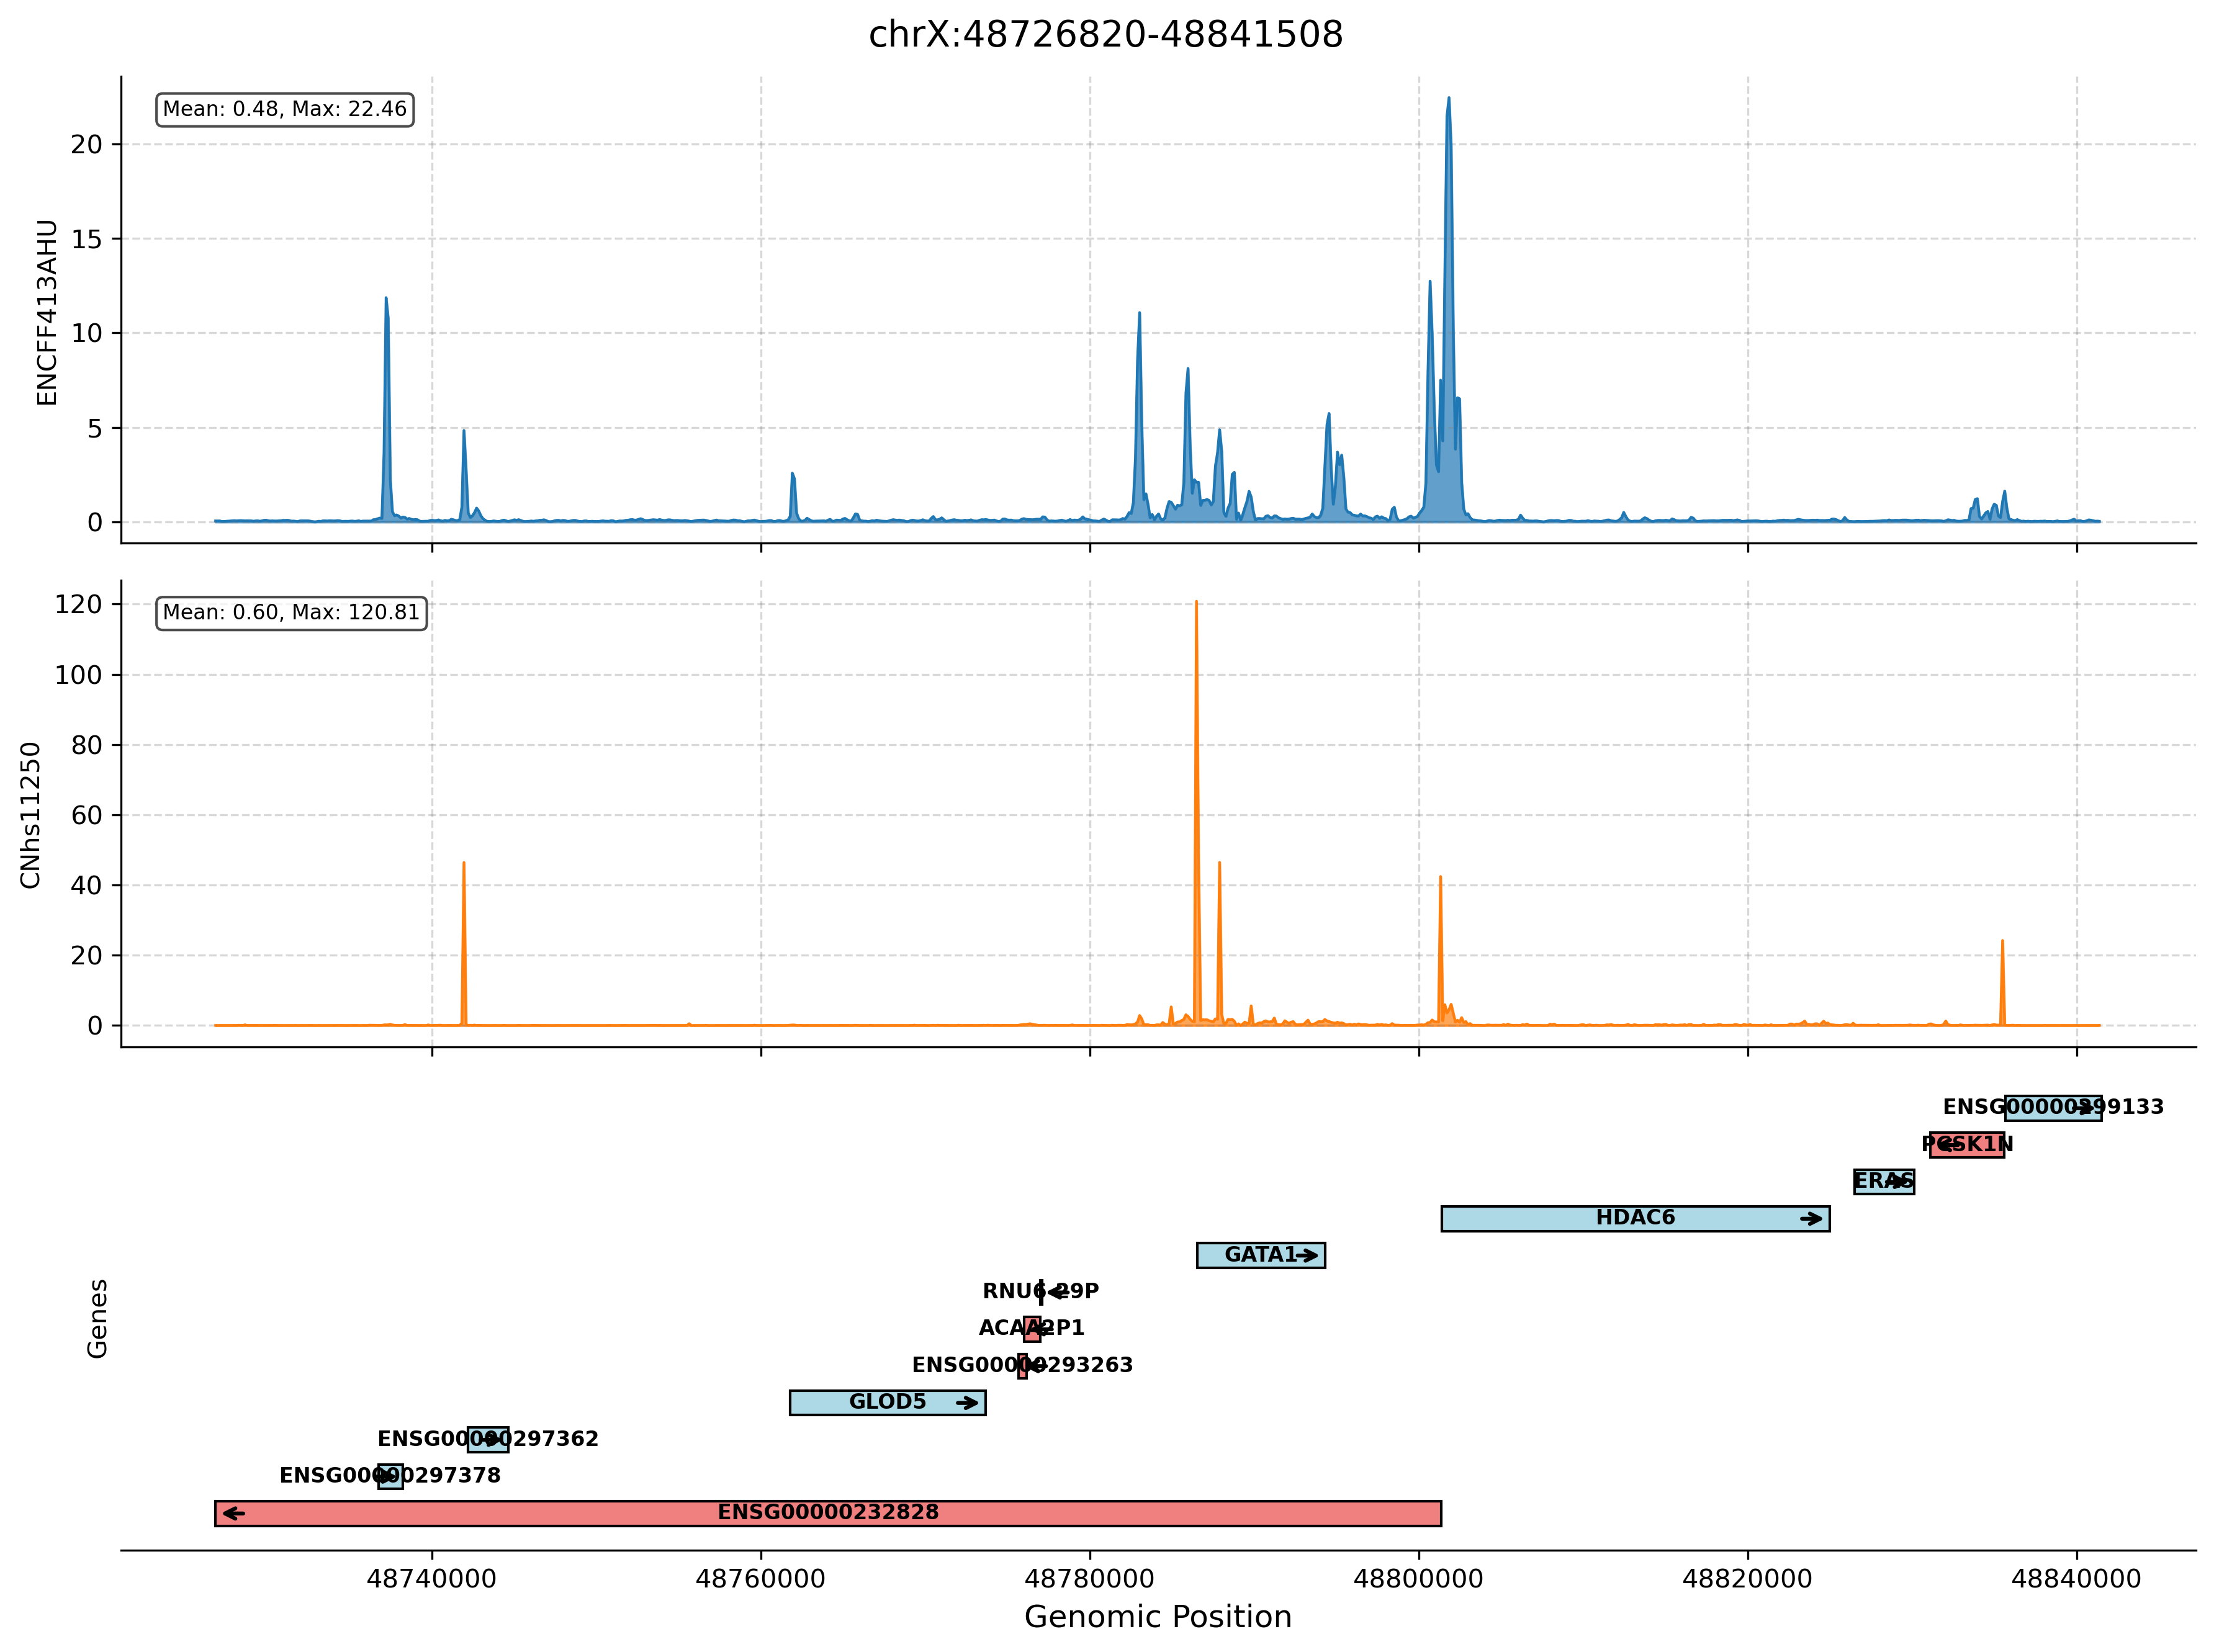

In [29]:
# Create comprehensive visualization with all tracks and genes
print("Creating comprehensive visualization with gene annotations...")

# Check if BedGraph files exist
import os
bedgraph_files = []
if os.path.exists("bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph"):
    bedgraph_files.append("bedgraph_outputs/a_wt_ENCFF413AHU.bedgraph")
if os.path.exists("bedgraph_outputs/a_wt_CNhs11250.bedgraph"):
    bedgraph_files.append("bedgraph_outputs/a_wt_CNhs11250.bedgraph")

if bedgraph_files:
    print(f"Found {len(bedgraph_files)} BedGraph files")
    
    # Get output window coordinates (from Example A)
    region_center = (48777634 + 48790694) // 2
    output_start, output_end = oracle.get_output_window_coords(region_center)
    
    # Focus on GATA1 region
    vis_start = 48780000
    vis_end = 48800000
    
    # Create a matplotlib visualization with genes
    print("\nCreating matplotlib visualization...")
    visualize_chorus_predictions(
        predictions=wt_results,
        chrom='chrX',
        start=output_start,
        track_ids=track_ids,
        output_file='comprehensive_gata1_matplotlib.png',
        bin_size=128,
        style='modern',
        gtf_file=str(gtf_path),
        show_gene_names=True,
        use_pygenometracks=False  # Force matplotlib
    )
    print("Saved comprehensive figure to: comprehensive_gata1_matplotlib.png")
    
    # Display the saved image
    from IPython.display import Image, display
    display(Image('comprehensive_gata1_matplotlib.png', width=900))
    
else:
    print("BedGraph files not found. Please run Example A first.")
    print("\nAlternatively, creating a direct visualization...")
    
    # Direct visualization without saved files
    visualize_chorus_predictions(
        predictions=wt_results,
        chrom='chrX', 
        start=output_start,
        track_ids=track_ids,
        output_file=None,  # Display inline
        bin_size=128,
        style='modern',
        gtf_file=str(gtf_path),
        show_gene_names=True,
        use_pygenometracks=False
    )